# Lecture 24 - Bayesian Model Selection using Sequential Monte Carlo

## Objectives

+ Compute the model evidence using [pysmc](https://github.com/PredictiveScienceLab/pysmc).
+ Do model selection with [pysmc](https://github.com/PredictiveScienceLab/pysmc).

In [3]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
#import design
#import orthpol
import warnings
warnings.filterwarnings('ignore')
#from tqdm import tqdm # pip install tqdm (or conda)
import sklearn
import pymc as pm
import pysmc as ps


# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in xrange(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

## Sanity check - Does the calculation of the evidence with PySMC work?

Let
$$
p(\theta) = \mathcal{N}(\theta|0, 1),
$$
and
$$
p(y|\theta) = \mathcal{N}(y|\theta,0).
$$
The posterior of $\theta$ given $y$ is:
$$
p(\theta|y) = \frac{p(y|\theta)p(\theta)}{Z},
$$
where
$$
Z = \int_{-\infty}^{\infty} p(y|\theta)p(\theta)d\theta.
$$
Let's first calculate $Z$ analytically.

In [4]:
import sympy
import sympy.stats
sympy.init_printing()
y, t = sympy.symbols('y \\theta')
q = 1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * (y - t) ** 2) * \
    1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * t ** 2)
sympy.simplify(sympy.integrate(q, (t, -sympy.oo, sympy.oo)))

So, if the observed $y$ was zero, then the Z should be:
$$
Z = \frac{1}{2\sqrt{\pi}}.
$$

In [5]:
Z = 1 /  2. / np.sqrt(np.pi)
print 'log Z = {0:1.3e}'.format(np.log(Z))

log Z = -1.266e+00


All, right. Now, let's program this thing in pysmc and compare the results.

We start with the model:

In [6]:
def make_model(y=0.):
    # The gamma parameter
    gamma = 1.
    
    # The prior over theta
    theta = pm.Normal('$\theta$', mu=0., tau=1., value=0.)
    
    # The likelihood term - which must contain gamma in it
    @pm.stochastic(observed=True)
    def likelihood(value=y, gamma=gamma, theta=theta):
        return gamma * pm.normal_like(value, theta, 1.)
    
    return locals()

Now we initialize the model and run PySMC.

In [7]:
model = make_model(y=0.)
mcmc = pm.MCMC(model)
mcmc.use_step_method(ps.RandomWalk, model['theta'])
smc = ps.SMC(mcmc, num_particles=100, num_mcmc=1, verbose=4, ess_reduction=0.9)
smc.initialize(0.)
smc.move_to(1.)

------------------------
START SMC Initialization
------------------------
- initializing at gamma : 0.0
- initializing by sampling from the prior: SUCCESS
----------------------
END SMC Initialization
----------------------
-----------------
START SMC MOVE TO
-----------------
initial  gamma : 0.0
final gamma : 1.0
ess reduction:  0.9
- tuning the MCMC parameters:
	- tuning step method: <pysmc._step_methods.RandomWalk object at 0x1038e5450>
- finding next gamma.
- moving to gamma : 0.717486768097
- performing 1 MCMC step(s) per particle
- ESS  = 90.00 %
- logZ = -9.486e-01
 [-----------------100%-----------------] 99 of 99 complete in 0.0 sec
- acceptance rate for each step method:
	- <pysmc._step_methods.RandomWalk object at 0x1038e5450> : 0.95
- tuning the MCMC parameters:
	- tuning step method: <pysmc._step_methods.RandomWalk object at 0x1038e5450>

		adaptive_scale_factor: 1.1

		SUCCESS
- finding next gamma.
- 	we can move directly to the target gamma...
- moving to gamma : 1.0
-

Here are the log Z ratios that we gathered along the way:

In [8]:
print smc.log_Zs

[-0.94857829434701113, -0.3387934913175199]


The evidence is the sum of these:

In [9]:
print 'Log Z SMC estiamte: {0:1.6e}'.format(np.sum(smc.log_Zs))

Log Z SMC estiamte: -1.287372e+00


Which is close to the truth.

## Questions
+ Repeat the calculations above for a varying number of SMC particles. Start from 10 and go up to 10,000.

## Polynomial Regression

We are going to implement a standard Bayesian linear regression using pymc and train it with pysmc.
We will compute the evidence in order to select the best class of basis functions.

The model is as follows. The output $y$ conditioned on the input $x$, the weights of the basis functions $w$ and
the noise variance $\sigma^2$ has likelihood:
$$
p(y|x,w,\sigma, \mathcal{M}) = \mathcal{N}(y|w^T\phi_{\mathcal{M}}(x), \sigma^2),
$$
where $\phi_{\mathcal{M},1}(\cdot), \dots, \phi_{\mathcal{M},m_{\mathcal{M}}}(\cdot)$ are the
$m_{\mathcal{M}}$ basis functions of the model $\mathcal{M}$.
We put a normal prior on the weights:
$$
p(w|\alpha) = \mathcal{N}(w|0, \alpha I_{m_{\mathcal{M}}}),
$$
and an inverse Gamma prior for $\sigma$ and $\alpha$:
$$
p(\sigma^2) = \mbox{IG}(\sigma^2|1, 1),
$$
and
$$
p(\alpha) = \mbox{IG}(\alpha|1,1).
$$

Assume that the data we have observed are:
$$
x_{1:n} = \{x_1,\dots,x_n\},\;\mbox{and}\;y_{1:n} = \{y_1,\dots,y_n\}.
$$
Consider the design matrix $\Phi_{\mathcal{M}}\in\mathbb{R}^{n\times m}$:
$$
\Phi_{\mathcal{M},ij} = \phi_{\mathcal{M},j}(x_i).
$$
The likelihood of the data is:
$$
p(y_{1:n} | x_{1:n}, w, \sigma, \mathcal{M}) = \mathcal{N}(y_{1:n}|\Phi_{\mathcal{M}}w, \sigma^2I_n).
$$
Let's turn this into pymc code.

In [10]:
def make_model(Phi, y):
    # The parameter gamma
    gamma = 1.
    # The prior for sigma
    sigma2 = pm.InverseGamma('sigma2', .5, 0.5)
    # The prior for alpha
    alpha = pm.InverseGamma('alpha', .5, .5)
    # The prior of the weights
    w = pm.Normal('w', mu=np.zeros(Phi.shape[1]), tau=alpha)
    # The likelihood
    @pm.stochastic(observed=True)
    def likelihood(value=y, Phi=Phi, gamma=gamma, w=w, sigma2=sigma2):
        return gamma * pm.normal_like(value, np.dot(Phi, w), 1. / sigma2)
    return locals()

Let's generate some fake data to play with:

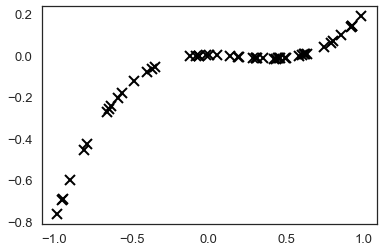

In [11]:
np.random.seed(12345)
num_samples = 50
sigma2 = 1e-6
X = 2 * np.random.rand(num_samples) - 1.
y = 0.5 * X  ** 3 - 0.3 * X ** 2 + np.sqrt(sigma2) * np.random.rand(num_samples)
plt.plot(X, y, 'kx', markeredgewidth=2)

Now, let's create a function that trains the model using pysmc for a polynomial basis with a given order.

In [12]:
def fit_poly(phi, X, y, num_particles=100, verbose=0):
    Phi = compute_design_matrix(X[:, None], phi)
    model = make_model(Phi, y)
    mcmc = pm.MCMC(model)
    mcmc.use_step_method(ps.RandomWalk, model['w'])
    mcmc.use_step_method(ps.LognormalRandomWalk, model['alpha'])
    mcmc.use_step_method(ps.LognormalRandomWalk, model['sigma2'])
    smc = ps.SMC(mcmc, num_particles=num_particles, num_mcmc=10, verbose=verbose, ess_reduction=0.95)
    smc.initialize(0.)
    smc.move_to(1.)
    return smc

Now, let's define a function that plots the posteriors of everything.

In [13]:
def plot_posteriors(smc):
    pa = smc.get_particle_approximation()
    pa.resample()
    W = pa.w
    fig, ax = plt.subplots()
    for j in xrange(W.shape[1]):
        ax.hist(W[:, j], normed=True, alpha=0.5, label='$w_{%d}$' % j)
    plt.legend(loc='best')
    fig, ax = plt.subplots()
    alpha = pa.alpha
    ax.hist(alpha, normed=True, label='$\alpha$', alpha=0.5)
    ax.set_xlabel('alpha')
    fig, ax = plt.subplots()
    sigma2 = pa.sigma2
    ax.hist(sigma2, normed=True, label='$\sigma^2$', alpha=0.5)
    ax.set_xlabel('sigma2')

Let's also have a function that plots the predictive distribution:

In [14]:
def plot_predictive(phi, smc, num_samples=100):
    Xt = np.linspace(-1, 1, 100)
    Phit = compute_design_matrix(Xt[:, None], phi)
    pa = smc.get_particle_approximation()
    pa.resample()
    W = pa.w
    sigma2 = pa.sigma2
    # We find the percantiles numerically
    Ys = np.ndarray((num_samples * pa.num_particles, Phit.shape[0]))
    for i in xrange(W.shape[0]):
        w = W[i, :]
        sigma = np.sqrt(sigma2[i])
        Yt = np.dot(Phit, w)
        for j in xrange(num_samples):
            Ys[i * num_samples + j, :] = Yt + sigma * np.random.randn(*Yt.shape)
    Ym = np.percentile(Ys, 50, axis=0)
    Yu = np.percentile(Ys, 97.5, axis=0)
    Yl = np.percentile(Ys, 2.5, axis=0)
    fig, ax = plt.subplots()
    ax.plot(Xt, Ym, color=sns.color_palette()[0])
    ax.fill_between(Xt, Yl, Yu, color=sns.color_palette()[0], alpha=0.25)
    ax.plot(X, y, 'kx', markeredgewidth=2)

------------------------
START SMC Initialization
------------------------
- initializing at gamma : 0.0
- initializing by sampling from the prior: SUCCESS
----------------------
END SMC Initialization
----------------------
-----------------
START SMC MOVE TO
-----------------
initial  gamma : 0.0
final gamma : 1.0
ess reduction:  0.95
- moving to gamma : 0.00413338884621
- performing 10 MCMC step(s) per particle
- ESS  = 95.00 %
- logZ = -3.607e-01

- moving to gamma : 0.0083291261436
- performing 10 MCMC step(s) per particle
- ESS  = 90.25 %
- logZ = -3.310e-01

- moving to gamma : 0.0116760087872
- performing 10 MCMC step(s) per particle
- ESS  = 85.74 %
- logZ = -2.416e-01

- moving to gamma : 0.015459626482
- performing 10 MCMC step(s) per particle
- ESS  = 81.45 %
- logZ = -2.697e-01

- moving to gamma : 0.0196581693528
- performing 10 MCMC step(s) per particle
- ESS  = 77.38 %
- logZ = -2.806e-01

- moving to gamma : 0.0235239637212
- performing 10 MCMC step(s) per particle
- E


- moving to gamma : 0.827584151271
- performing 10 MCMC step(s) per particle
- ESS  = 77.38 %
- logZ = 6.249e-01

- moving to gamma : 0.841629467006
- performing 10 MCMC step(s) per particle
- ESS  = 73.51 %
- logZ = 5.864e-01

- moving to gamma : 0.854908295228
- performing 10 MCMC step(s) per particle
- ESS  = 69.83 %
- logZ = 5.608e-01

- resampling
- moving to gamma : 0.870560439016
- performing 10 MCMC step(s) per particle
- ESS  = 100.00 %
- logZ = 6.679e-01

- moving to gamma : 0.907261645004
- performing 10 MCMC step(s) per particle
- ESS  = 95.00 %
- logZ = 1.641e+00

- moving to gamma : 0.929957959846
- performing 10 MCMC step(s) per particle
- ESS  = 90.25 %
- logZ = 1.031e+00

- moving to gamma : 0.94890186509
- performing 10 MCMC step(s) per particle
- ESS  = 85.74 %
- logZ = 8.660e-01

- moving to gamma : 0.968352259895
- performing 10 MCMC step(s) per particle
- ESS  = 81.45 %
- logZ = 8.946e-01

- moving to gamma : 0.986552308464
- performing 10 MCMC step(s) per partic

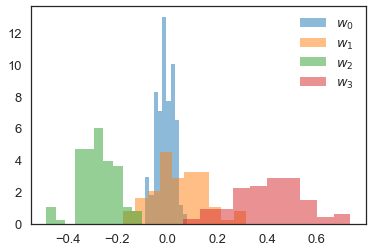

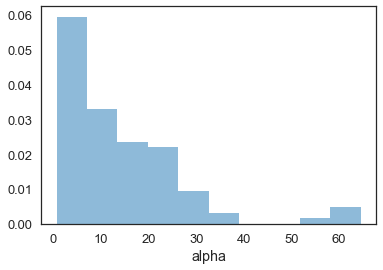

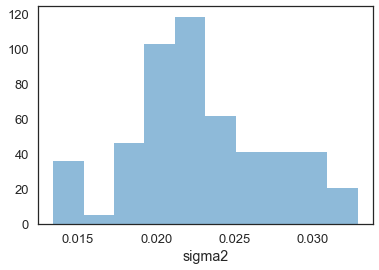

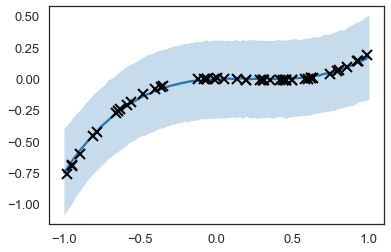

In [15]:
phi = PolynomialBasis(3)
smc = fit_poly(phi, X, y, num_particles=100, verbose=1)
plot_posteriors(smc)
plot_predictive(phi, smc)

Now, we can compute and compare the evidence of all  models:

In [16]:
# Evaluate the evidence for the various degrees
log_Zs = []
for d in [1, 2, 3, 4, 5]:
    phi = phi = PolynomialBasis(d)
    smc = fit_poly(phi, X, y, num_particles=100)
    log_Z = np.sum(smc.log_Zs)
    print 'degree {0:1d} gives {1:1.3e}'.format(d, log_Z)
    log_Zs.append(log_Z)

degree 1 gives 7.992e+00
degree 2 gives 1.212e+01
degree 3 gives 1.680e+01
degree 4 gives 1.619e+01
degree 5 gives 1.623e+01


In [17]:
X.shape

<BarContainer object of 5 artists>

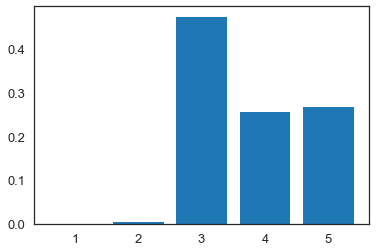

In [18]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(log_Zs) + 1), np.exp(log_Zs) / np.sum(np.exp(log_Zs)))

## Questions
+ The model with degree 3 polynomials has the gradest evidence. However, the degree 4 and 5 seem also very plaussible. Is this a problem for the theory of Bayesian model selection? What complicates things here, is that model 3 is included in model 4 which is included in model 5. This requires us to design special priors for the models being right. They have to be consistent in some sense. For example, if model 3 is right then model 4 must be right, etc.

+ In the space below, we load the motorcycle data. By copy pasting the code above and by making small modifications, evaluate the model evidence for a 1) Polynomial basis; 2) a Fourier basis; and 3) a Radial basis function basis. Feel free to pick the parameters of these basis functions to be the best we found in [Lecture 9](./lec_09.ipynb).

# Revisiting Challenger Disaster Problem (Model Selection)


Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


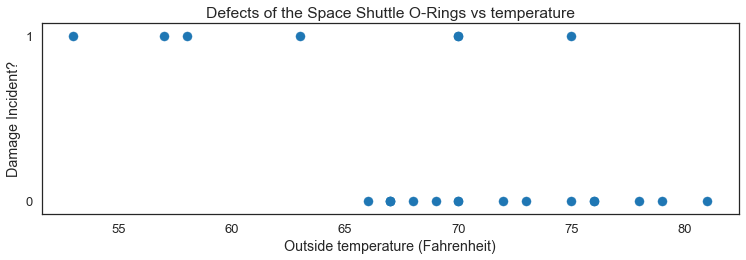

In [20]:
from IPython.core.pylabtools import figsize
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1])
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In [ ]:
def make_model(feat, y):
    """
    PyMC model (wrapping all the data and variables into a single function)
    Inputs:
    challenger data (23 x 2): Pandas dataframe ( Outside Temp vs. Damage Incident)
    Outputs:
    alpha, beta : stochastic parameters associated with the given model
    """
    gamma = 1.
    # Load data
    
    feat_scaled = (feat - np.mean(feat))/np.std(feat) # to ensure proper mixing of MCMC chains
    #D = challenger_data[:, 1]  # defect or not?
    
    # Define Prior
    beta = pm.Normal("beta", 0, 0.1, value = 0) # 0 mean and small 0.001 precision - vague prior
    alpha = pm.Normal("alpha", 0, 0.1, value = 0)
    
    @pm.deterministic
    def p(t=feat_scaled, alpha=alpha, beta=beta):
        return 1.0 / (1. + np.exp(beta * t + alpha))
    
    # Define likelihood
    # connect the probabilities in `p` with our observations through a
    # Bernoulli random variable.
    @pm.stochastic(observed = True)
    def likelihood(value = y, p = p, gamma = gamma):
        return gamma*pm.bernoulli_like(value, p)
    return locals()

import mpi4py.MPI as mpi

def fit_smc(feat,y, num_particles=100, verbose=0):
    model = make_model(feat,y)
    mcmc = pm.MCMC(model)
    mcmc.use_step_method(ps.RandomWalk, model['beta'])
    mcmc.use_step_method(ps.RandomWalk, model['alpha'])
    smc = ps.SMC(mcmc, num_particles=num_particles, num_mcmc=20,
                 verbose=verbose,mpi=mpi, ess_reduction=0.95)
    smc.initialize(0.)
    smc.move_to(1.)
    return smc

In [ ]:
temp = challenger_data[:,0]
y = challenger_data[:,1]
smc = fit_smc(temp,y, num_particles= 500, verbose=1)

In [ ]:
def plot_posterior(smc):
    pa = smc.get_particle_approximation()
    pa.resample()
    fig, ax = plt.subplots()
    alpha = pa.alpha
    ax.hist(alpha, normed=True, label='$\alpha$', alpha=0.5)
    ax.set_xlabel('alpha')
    fig, ax = plt.subplots()
    beta = pa.beta
    ax.hist(beta, normed=True, label='$\beta^2$', alpha=0.5)
    ax.set_xlabel('beta')

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

def plot_predictive(challenger_data, smc, num_samples=500):
    pa = smc.get_particle_approximation()
    pa.resample()
    alpha = pa.alpha
    beta = pa.beta
    
    temp = challenger_data[:, 0]
    D = challenger_data[:, 1]
    t = np.linspace(temp.min() - 5, temp.max() + 5, 50)[:, None]
    t_scaled = (t - np.mean(temp))/np.std(temp)
    p_t = logistic(t_scaled.T, beta[:,None], alpha[:,None])

    mean_prob_t = p_t.mean(axis=0)
    # vectorized bottom and top 2.5% quantiles for "confidence interval"
    qs = mquantiles(p_t, [0.025, 0.975], axis=0)
    plt.fill_between(t[:, 0], *qs, alpha=0.7,
                     color="#7A68A6")

    plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

    plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
             label="average posterior \nprobability of defect")

    plt.xlim(t.min(), t.max())
    plt.ylim(-0.02, 1.02)
    plt.legend(loc="lower left")
    plt.scatter(temp, D, color="k", s=50, alpha=0.5)
    plt.xlabel("temp, $t$")

    plt.ylabel("probability estimate")
    plt.title("Posterior probability estimates given temp. $t$");

In [ ]:
plot_posterior(smc)

In [ ]:
plot_predictive(challenger_data, smc, num_samples=500)

# Feature Selection

We knew that temperature was a relevant feature for predicting the probability of failure of O-rings since there are numerous studies published which illustrates this fact.

But when dealing with your own problem, you might not know which feature is relevant/important. For example, we have not considered Leak-check pressure (psi) for predicting the probability of failure (which is available in whole Challenger disaster data UCI data repository (https://archive.ics.uci.edu/ml/datasets/Challenger+USA+Space+Shuttle+O-Ring). Let us see if we can predict the probability of failure using leak check pressure feature.

In [ ]:
c2_data = np.loadtxt('challenger2.txt')
leak_pressure = c2_data[:,3]
smc2 = fit_smc(leak_pressure,y, num_particles= 500, verbose=1)

In [ ]:
log_Zs = [np.sum(smc.log_Zs), np.sum(smc2.log_Zs)]
print 'When we use temp as feature, log evidence is :', str(log_Zs[0])
print 'When we use leak pressure as feature, log evidence is :', str(log_Zs[1])

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(log_Zs) + 1), np.exp(log_Zs) / np.sum(np.exp(log_Zs)))

# Motor Cycle Data Visualization

In [ ]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [ ]:
import pymc as pm
def make_model(Phi, y):
    # The parameter gamma
    gamma = 1.
    # The prior for sigma
    sigma1 = pm.Exponential('sigma1', 0.1)
    sigma2 = pm.Exponential('sigma2', 0.1)
    # The prior of the weights
    w = pm.Normal('w', mu=np.zeros(Phi.shape[1]), tau= 1./sigma1**2)
    # The likelihood
    @pm.stochastic(observed=True)
    def likelihood(value=y, Phi=Phi, gamma=gamma, w=w, sigma2=sigma2):
        return gamma * pm.normal_like(value, np.dot(Phi, w), 1. / sigma2**2)
    return locals()

In [ ]:
def plot_posterior(smc):
    pa = smc.get_particle_approximation()
    pa.resample()
    W = pa.w
    fig, ax = plt.subplots()
    for j in xrange(W.shape[1]):
        ax.hist(W[:, j], normed=True, alpha=0.5, label='$w_{%d}$' % j)
    #plt.legend(loc='best')
    fig, ax = plt.subplots()
    sigma1 = pa.sigma1
    ax.hist(sigma1, normed=True, label='$\alpha$', alpha=0.5)
    ax.set_xlabel('sigma1')
    fig, ax = plt.subplots()
    sigma2 = pa.sigma2
    ax.hist(sigma2, normed=True, label='$\sigma^2$', alpha=0.5)
    ax.set_xlabel('sigma2')
    
def plot_predictive(phi, smc, num_samples=100):
    Xt = np.linspace(0, 60, 100)
    Phit = compute_design_matrix(Xt[:,None], phi)
    pa = smc.get_particle_approximation()
    pa.resample()
    W = pa.w
    
    p_t = np.dot(W,Phit.T)
    mean_prob_t = np.mean(p_t, axis = 0)

    # vectorized bottom and top 2.5% quantiles for "confidence interval"
    qs = mquantiles(p_t, [0.025, 0.975], axis=0)
    plt.fill_between(Xt, *qs, alpha=0.7,
                     color="#7A68A6")

    plt.plot(Xt, qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

    plt.plot(Xt, mean_prob_t, lw=1, ls="--", color="k",
             label="average posterior")

    plt.xlim(Xt.min(), Xt.max())
    plt.legend(loc="best")
    plt.scatter(X, Y, color="k", s=50, alpha=0.5)

In [ ]:
ell = 5.
smc = fit_radial(ell, X, Y, num_particles=500, verbose=1)

In [ ]:
plot_posterior(smc)

In [ ]:
phi = RadialBasisFunctions(X, ell)
plot_predictive(phi, smc, num_samples=500)

In [ ]:
# Evaluate the evidence for the various degrees
log_Zs = []
for ell in [2, 5]:
    smc = fit_radial(ell, X, Y, num_particles=500, verbose=1)
    log_Z = np.sum(smc.log_Zs)
    log_Zs.append(log_Z)

In [ ]:
ells = [2, 5]
for i in xrange(5):
    print 'For ell = ' + str(ell) + ', evidence is : ' + str(log_Zs[i])

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(log_Zs) + 1), np.exp(log_Zs) / np.sum(np.exp(log_Zs)))